# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import _pickle as pickle
import os

# TODO: Fill this in based on where you saved the training and testing data
data_dir = 'traffic-signs-data'
training_file = os.path.join(data_dir,'train.p')
testing_file = os.path.join(data_dir,'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import matplotlib.image as mpimg
import random

def split_by_class(y_data) :
    """
    Returns a dictionary whose keys are the class labels 
    and key values are list of indices with that class label.
    """
    img_index = {}
    labels = set(y_data)
    for i,y in enumerate(y_data) :
        if y not in img_index.keys() :
            img_index[y] = [i]
        else :
            img_index[y].append(i)
    return img_index
    

def display_sample_images(X_data, y_data, i_start='random') :
    """
    Displays images from each class, 
    i_start is the starting index in each class.
    By default, images are randomly chosen from each class
    """
    img_index = split_by_class(y_data)
    labels = list(set(y_data))[::-1]
    fig, axes = plt.subplots(3, 15, figsize=(15, 3))
    for ax in axes.flatten() :
        if labels : 
            i_img=0
            if i_start == 'random':
                i_img = random.choice(img_index[labels.pop()])  
            else : 
                i_img = img_index[labels.pop()][i_start]
            ax.imshow(X_train[i_img])
        ax.axis('off')

### Variation within each class
There seems to be a significant variation in lighting for randomly chosen images within a class. This is illustarted in two randomly chosen samples from each class :

**Random sample of images from each class**

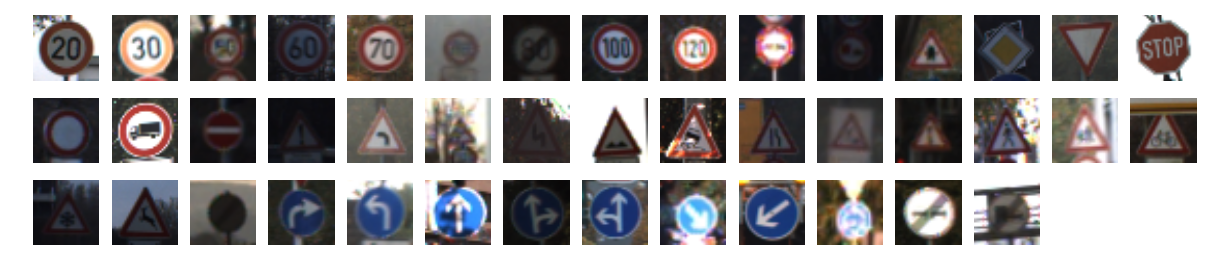

In [4]:
display_sample_images(X_train, y_train)

**Another random sample of images from each class**

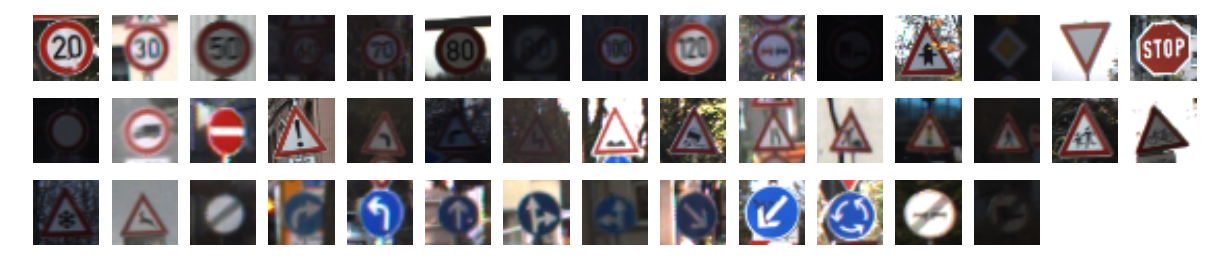

In [5]:
display_sample_images(X_train, y_train)

## Similarity in sequential images in training set
There seems to be similarity in sequential images probably because images were captured in close interval from the same vehicle. This is illustrated by two consecutive images (2nd and 3rd) taken from each class 

**1st image from each class**

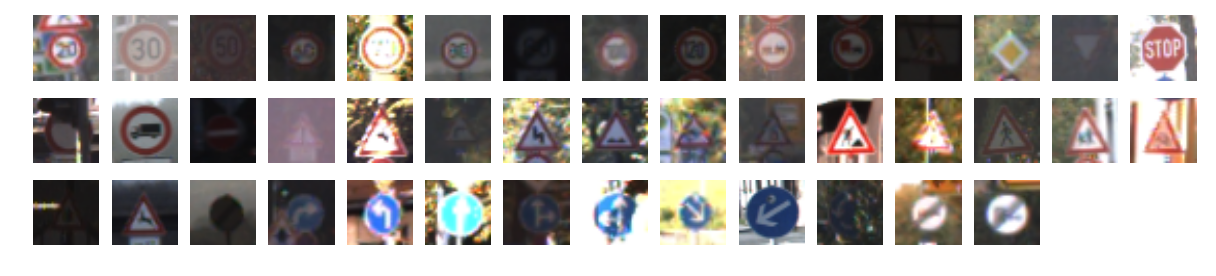

In [6]:
display_sample_images(X_train, y_train, i_start=0)

**2nd image from each class**

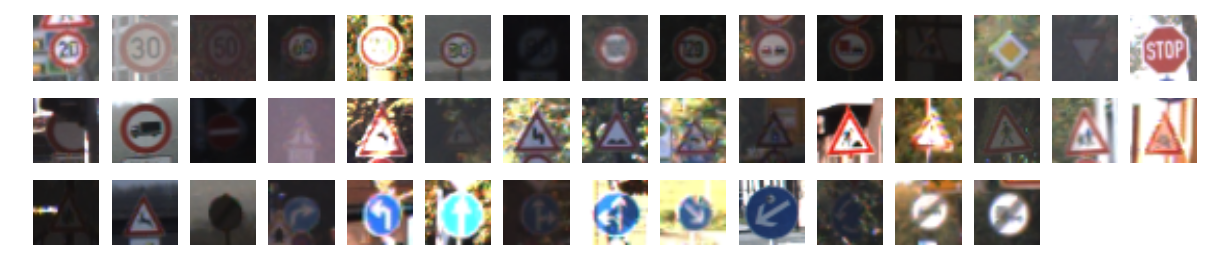

In [7]:
display_sample_images(X_train, y_train, i_start=1)

**3rd image from each class**

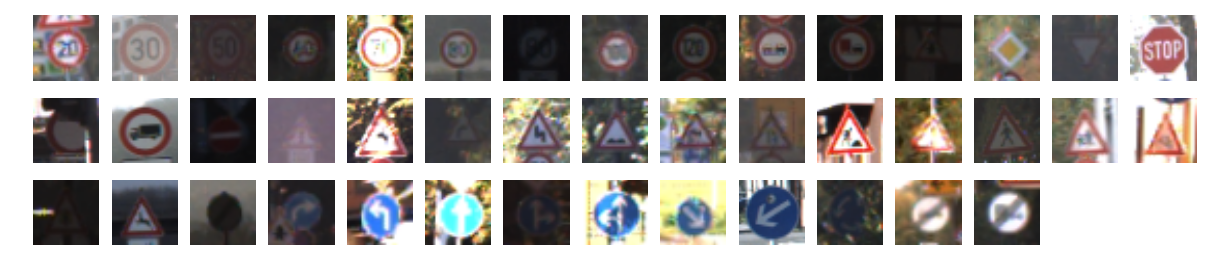

In [8]:
display_sample_images(X_train, y_train, i_start=2)

Here are the first 15 images from 5 class, clearly they look very similar

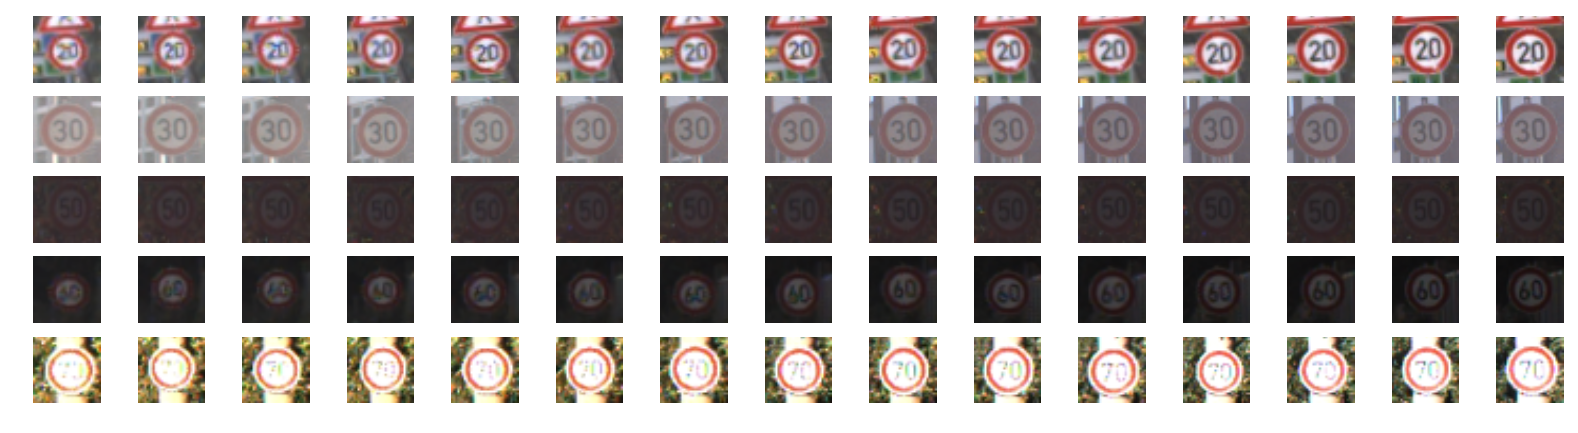

In [9]:
img_index = split_by_class(y_train)
fig, ax = plt.subplots(5,15, figsize=(20,5))
for label in range(5) :
    for i in range(15) :
        ax[label, i].imshow(X_train[img_index[label][i]])
        ax[label, i].axis('off')

## Grouping images by 'tracks'
Below we define a similarity index for two images and observe that many of the images are very similar. As explained above, this similarity arises because pictures were taken from the same vehicle at close intervals. We define such a group of images as a 'track' and we want to identify images which belong to the same track. This will be crucial because CNN trained on images in the same track will not be robust to new data. Further care has to be taken when we divide the data set into training and validation sets. 

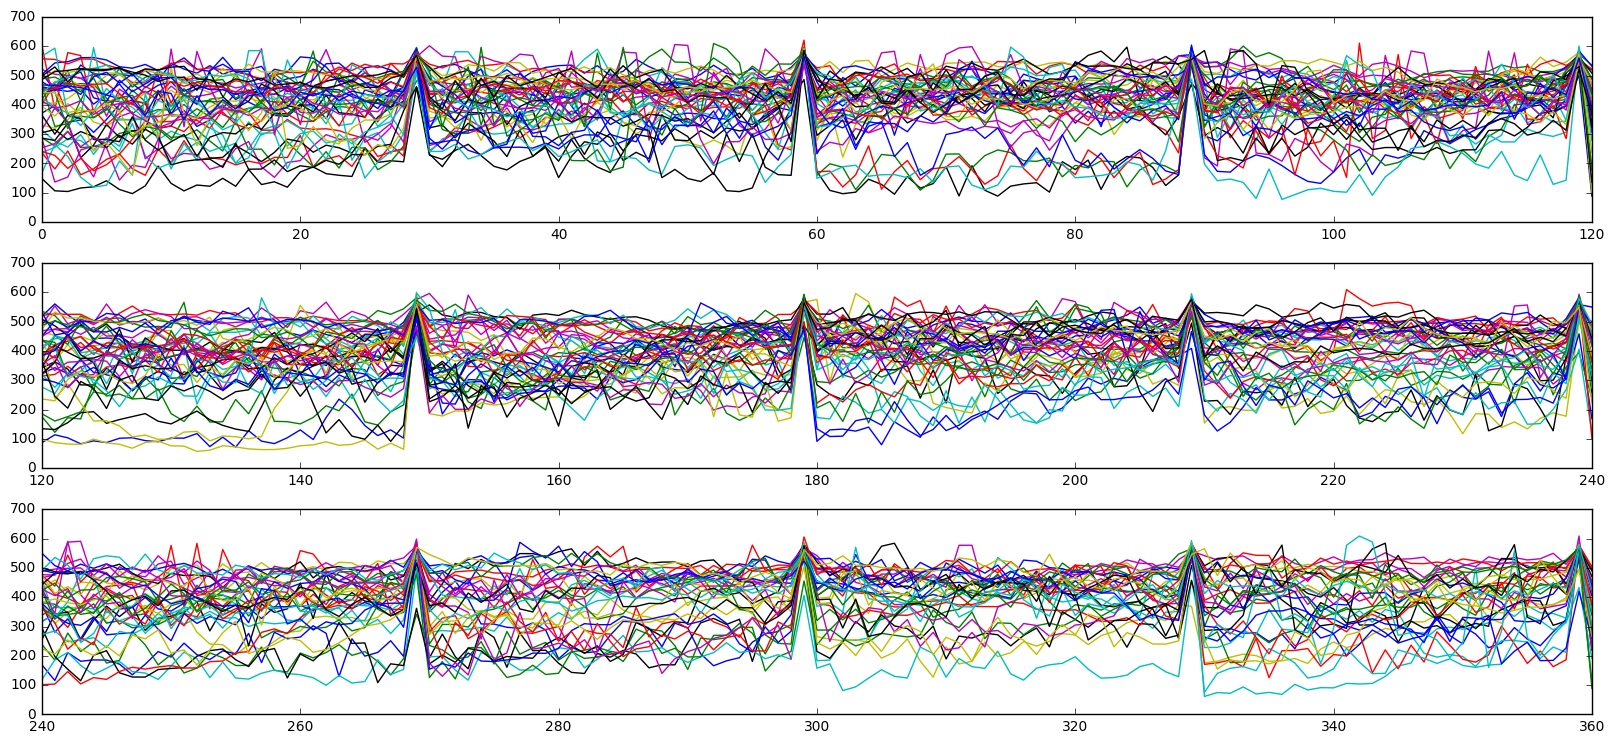

In [10]:
import numpy as np 
import cv2

def similarity_index(image1, image2) :
    """
    Determines how similar or different images are.
    A small value indicates very similar images. 
    """
    return (np.sum(np.square(image1.flatten()-image2.flatten())))**.5

def display_image_similarity(X_data,y_data, nrows=3) :
    img_index = split_by_class(y_data)
    fig, axes = plt.subplots(nrows, 1, figsize=(20,3*nrows))
    for i,ax in enumerate(axes) :
        ax.set_xlim([i*120, (i+1)*120])
    for label in range(n_classes) :
        sim = []
        for i in range(1, len(img_index[label])) :
            sim.append(similarity_index(X_data[img_index[label][i]], X_data[img_index[label][i-1]]))
        for ax in axes :
            ax.plot(sim)
        
display_image_similarity(X_train,y_train)

The spikes clearly visible in the above dataset mark separation of tracks at intervals of 30 images. 
We will use this information later to divide the dataset into training and test tests.  

**In the test set, no such similarity is observed between consecutive images :**

Also, note that similarity index is much higher on average meaning the consecutive images are very different

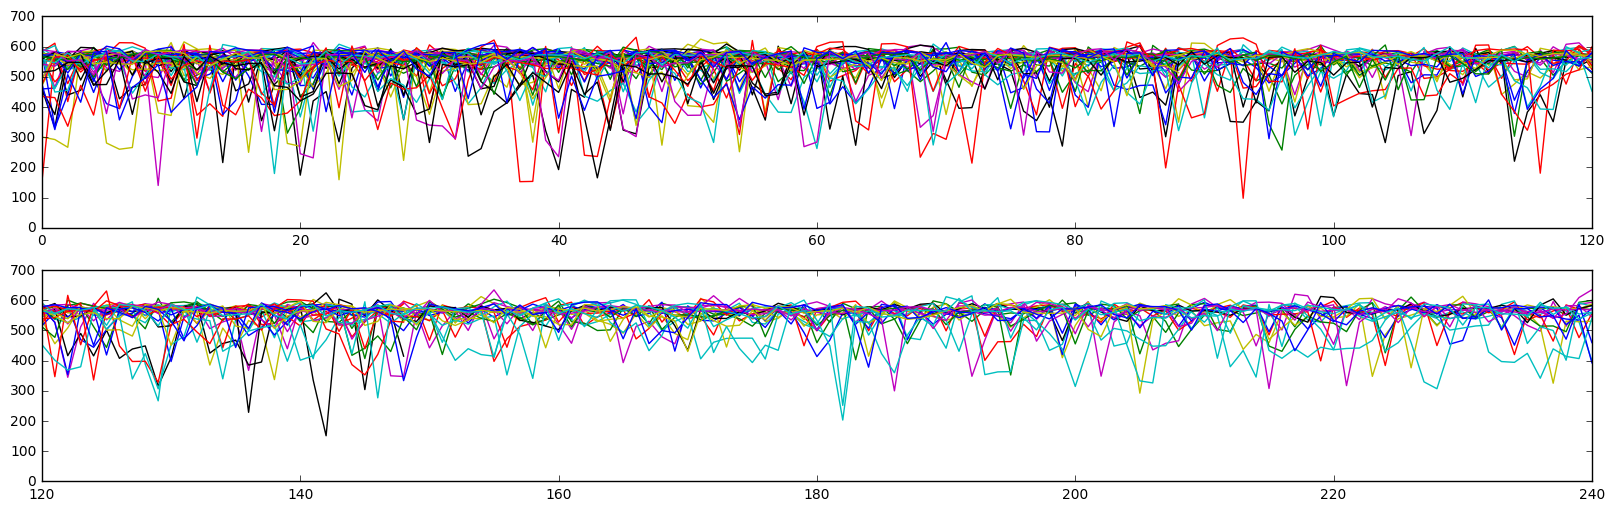

In [11]:
display_image_similarity(X_test,y_test, nrows=2)

## Distribution of images in the classes
The dataset seems to be imbalanced as illustrated below.

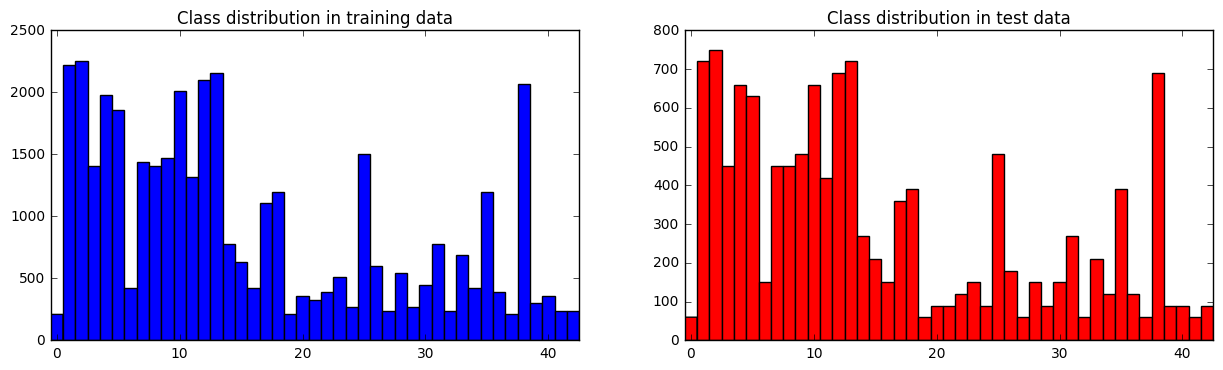

In [12]:
def plot_dist(y_data, title=None, ax=None, **kwargs) :
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_classes+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5,n_classes-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,2, figsize=(15,4))
plot_dist(y_train, title='Class distribution in training data', ax=ax[0])
plot_dist(y_test, title='Class distribution in test data', ax=ax[1], color='red')

The class ditribution in train and test sets look very similar. Even if we did not balance dataset, it is possible to obtain a reasonable accuracy for this particular testset. However, for new test sets with different class distributions, accuracy will go down. Therefore, we will balance our training set later by data augmentation.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

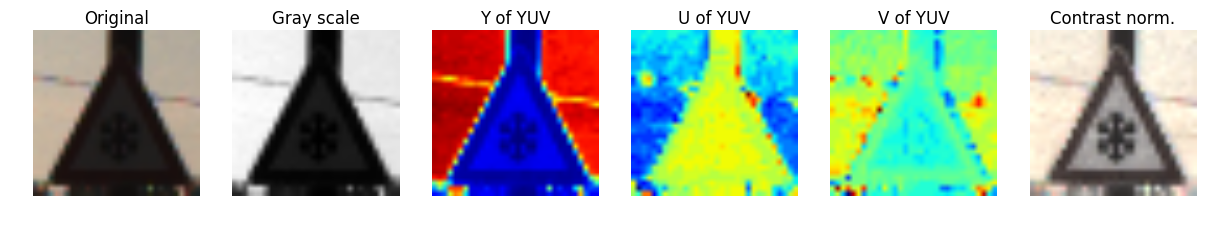

In [13]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import random
from sklearn.utils import shuffle

def MinMaxNorm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def AbsNorm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def grayscale_norm(image) :
    # convert to grayscale 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return MinMaxNorm(img)

def YUV_norm(image) :
    # convert to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # normalize the Y channel
    [y,u,v] = [new_image[:,:,i] for i in range(3)]
    new_image = np.zeros(image.shape)
    new_image[:,:,0] = MinMaxNorm(y)
    new_image[:,:,1],new_image[:,:,2] = AbsNorm(u), AbsNorm(v)
    return new_image

def contrast_norm(image) :
    # convert to  lab colorspace
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # apply adative histogram equalization 
    l = lab[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    lab[:,:,0] = cl
    # convert back to RGB and scale values 
    img =  cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    for i in range(3) :
        new_img[:,:,i] = AbsNorm(img[:,:,i])
    return new_img

img_index = split_by_class(y_train)
img = X_train[img_index[30][20]]
fig, ax = plt.subplots(1,6, figsize=(15,3))
for axes in ax :
    axes.axis('off')
# original image
ax[0].imshow(img)
ax[0].set_title('Original')
# grayscale normalized 
ax[1].imshow(grayscale_norm(img), cmap='gray')
ax[1].set_title('Gray scale')
# YUV normalized (Y channel) 
ax[2].imshow(YUV_norm(img)[:,:,0])
ax[2].set_title('Y of YUV')
# YUV normalized (U channel) 
ax[3].imshow(YUV_norm(img)[:,:,1])
ax[3].set_title('U of YUV')
# YUV normalized (V channel) 
ax[4].imshow(YUV_norm(img)[:,:,2])
ax[4].set_title('V of YUV')
# Contrast normalized 
ax[5].imshow(contrast_norm(img))
ax[5].set_title('Contrast norm.')

I checked that Y channel of YUV colorspace is almost identical to grayscale. However, adaptive histogram equilization clearly makes a big difference.  
___

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**  I tried several colorspaces, starting from original RGB followed by YUV where Y channel carries intensity information which was normalized for each image to adjust for variable lighting. I found that Y channel was almost identical to grayscale. However, this naive linear scaling is not always sufficient as evident in figure above where contrast adjustment makes a huge difference. After trial and error, I decided to use contrast limited adaptive histogram equilization (CLAHE) with tile size of 4x4. I used all color channels as this information is relevant for traffic signs. As a last step, I simply scaled RGB values to lie in the range [-0.5,0.5]. Note that actual pre-processing is applied later on in the code after data augmentaion.  

___

We want to separate the given data into training and validation sets. For robustness, we need to ensure that images in the same track do not get divided between training and validation sets since they are very similar. For validation set, we randomly select 2 tracks per class from the entire training dataset.  

New training data shape is :  (37919, 32, 32, 3)
Validation data shape is :  (1290, 32, 32, 3)


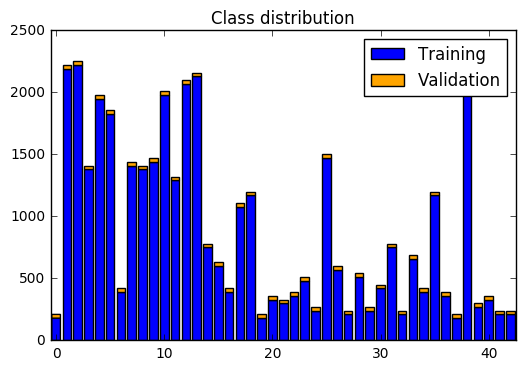

In [14]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


def split_train_validation(X_data, y_data) :
    """
    Splits data into training and validations sets based on tracks
    such that all images from a track are confined to either training 
    or validation sets but not both.
    """
    X_train_new, y_train_new = [],[]
    X_validation, y_validation = [], []
    
    n_per_track = 30 # images per track
    img_index = split_by_class(y_data)
    for label in range(n_classes) : 
        indices = img_index[label]
        n_tracks = round(len(indices)/n_per_track) # number of tracks for this label
        X_list = np.array_split(X_data[indices[0]:indices[-1]+1], n_tracks)
        y_list = np.array_split(y_data[indices[0]:indices[-1]+1], n_tracks)
        X_list,y_list = shuffle(X_list,y_list, random_state=0)
        X_validation += X_list[:1]
        y_validation += y_list[:1]
        X_train_new += X_list[1:]
        y_train_new += y_list[1:]
        
    return (np.concatenate(X_train_new), np.concatenate(y_train_new), 
            np.concatenate(X_validation), np.concatenate(y_validation))

# sanity check
X_train_new, y_train_new, X_validation, y_validation = split_train_validation(X_train, y_train)
print("New training data shape is : ", X_train_new.shape)
print("Validation data shape is : ", X_validation.shape)
plot_dist([y_train_new, y_validation], title='Class distribution', 
          label=['Training','Validation'], color=['blue','orange'])

Next, we need to generate fake data for several reasons : 
* To balance our dataset
* For training purposes, ideally we should have had lot of tracks and only a few images per track but this is not the case. 
* In general, small perturbations in our original dataset will increase robustness of CNNs later.

We will generate fake data by performing geometric transformations. Some useful functions for these transformations are defined below :

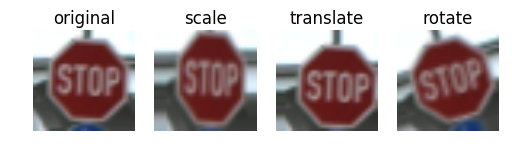

In [15]:
# geometric transformations

# scaling
def scale(img, x_scale=0.85, y_scale=1.15) :
    r,c = img.shape[:-1]
    scaled_img = cv2.resize(img,None,fx=x_scale,fy=y_scale)
    new_img = cv2.copyMakeBorder(scaled_img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]
    
# translation
def translate(img, delta_x=2, delta_y=-2):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2)+delta_y, round((cols-c)/2)-delta_x
    return new_img[r0:r0+r, c0:c0+c]

# rotation
def rotate(img, theta=18):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    new_img = cv2.warpAffine(new_img,M,(cols,rows))
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# check if the transformations work
img = X_train[img_index[14][200]]
def original(img) : return img
fig, ax = plt.subplots(1,4, figsize=(6,2))
for i,transform in enumerate([original, scale, translate, rotate]) :
    ax[i].imshow(transform(img))
    ax[i].axis('off')
    ax[i].set_title(transform.__name__)

Following code randomizes and combines the above image transformations

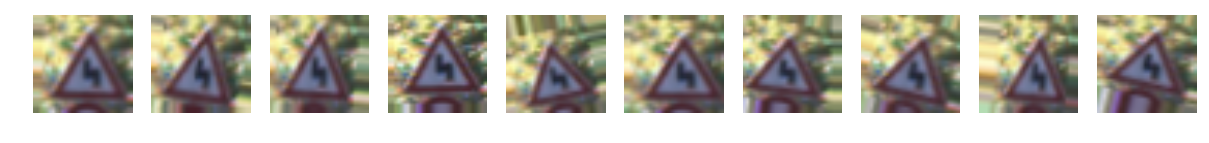

In [16]:
# implement random transforms
random_scale = lambda img : scale(img, x_scale=random.uniform(0.85,1.1), y_scale=random.uniform(0.85,1.1))
random_translate = lambda img : translate(img, delta_x=random.randint(-2,2), delta_y=random.randint(-2,2))
random_rotate = lambda img : rotate(img, theta=random.uniform(-17.,17.))

def random_transform(img) :
    new_img = img
    transform_list = [random_scale, random_translate, random_rotate]
    random.shuffle(transform_list)
    for transform in transform_list :
        new_img = transform(new_img)
    return new_img

# check
img = X_train[img_index[21][10]]
fig, ax = plt.subplots(1,10, figsize=(15,2))
for i in range(10) :
    ax[i].imshow(random_transform(img))
    ax[i].axis('off')

As already explained, we have a problem that most consecutive images are strongly correlated because they belong to the same track. To fix this problem, we apply random image transforms to every odd numbered image in training dataset with the idea being that consecutive images have similar resolution. Further, we augment existing dataset to make it balanced by requiring 3000 examples per class in training set.  

In [17]:
from tqdm import tqdm

def perturb_data(X_data, y_data):
    """
    splits dataset retaining half the original images 
    while perturbing the other half of the images 
    """
    X_old, y_old = [], []
    X_new, y_new = [], []
    images_pbar = tqdm(X_data, unit='images', desc='Original data perturbation')
    for i,img in enumerate(images_pbar) :
        if i%2 == 0 : 
            X_old.append(img) 
            y_old.append(y_data[i])
        else :
            X_new.append(random_transform(img))
            y_new.append(y_data[i])
    return (np.array(X_old), np.array(y_old), 
            np.array(X_new), np.array(y_new))
        

def augment_data(X_data, y_data, n=300):
    """
    augments dataset so that there are n images per class
    """
    X_data_fake, y_data_fake = [],[]
    img_index = split_by_class(y_data)
    labels_pbar = tqdm(range(n_classes), unit='class', desc='Data augmentation')
    for label in labels_pbar:
        n_fake = n-len(img_index[label])
        if n_fake <= 0 : continue
        for i in range(n_fake):
            i_img = random.choice(img_index[label])
            img = X_data[i_img]
            X_data_fake.append(random_transform(img))
            y_data_fake.append(label)
    return np.array(X_data_fake),np.array(y_data_fake)

In [18]:
# generate training data with 5000 images per class
from time import sleep
print('Training dataset augmentation')
sleep(1)
X_train_given, y_train_given, X_train_pert, y_train_pert = perturb_data(X_train_new, y_train_new)
X_train_fake, y_train_fake = augment_data(X_train_new, y_train_new, n=5000)
del X_train_new, y_train_new

Training dataset augmentation


Data augmentation: 100%|██████████| 43/43 [00:21<00:00,  1.79class/s]


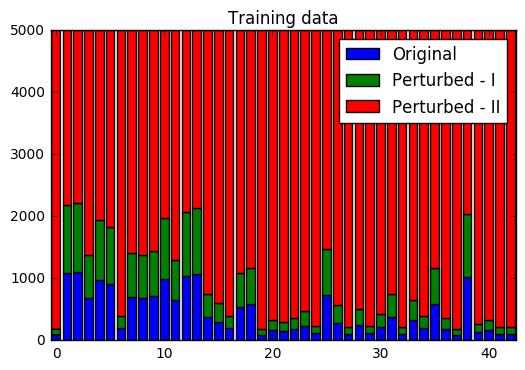

In [19]:
# check if distributions are as expected
plot_dist([y_train_given,y_train_pert, y_train_fake], title='Training data', \
          label=['Original','Perturbed - I','Perturbed - II'])

In [20]:
from sklearn.utils import shuffle
from time import sleep 

# combine training data, shuffle and apply pre-processing 
print('Preparing training data...')
X_train = np.concatenate((X_train_given, X_train_pert, X_train_fake))
y_train = np.concatenate((y_train_given, y_train_pert, y_train_fake))
X_train, y_train = shuffle(X_train, y_train)
del X_train_given, X_train_pert, X_train_fake, \
    y_train_given, y_train_pert, y_train_fake # free memory 
sleep(1)
images_pbar = tqdm(X_train, unit='images')
X_train = np.zeros(X_train.shape)
for i,img in enumerate(images_pbar) : 
    X_train[i] = contrast_norm(img) 
print('Done')

# combine validation data, shuffle and apply pre-processing 
print('Preparing validation data...')
X_validation, y_validation = shuffle(X_validation, y_validation)
sleep(1)
images_pbar = tqdm(X_validation, unit='images')
X_validation = np.zeros(X_validation.shape)
for i,img in enumerate(images_pbar) : 
    X_validation[i] = contrast_norm(img) 
print('Done')
    
# pre-process test set images
print('Preparing test data...')
sleep(1)
images_pbar = tqdm(X_test, unit='images')
X_test = np.zeros(X_test.shape)
for i,img in enumerate(images_pbar) : 
    X_test[i] = contrast_norm(img) 
sleep(1)

Preparing training data...


100%|██████████| 215000/215000 [00:51<00:00, 4188.75images/s]


Done
Preparing validation data...


100%|██████████| 1290/1290 [00:00<00:00, 4191.73images/s]


Done
Preparing test data...


100%|██████████| 12630/12630 [00:03<00:00, 4157.56images/s]


Training data shape :  (215000, 32, 32, 3)
Validation data shape :  (1290, 32, 32, 3)
Test data shape :  (12630, 32, 32, 3)


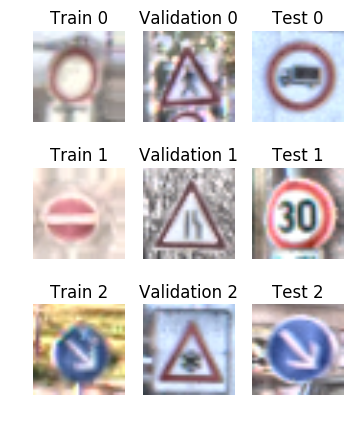

In [21]:
# sanity check : training, validation and test sets 
fig, ax = plt.subplots(3,3, figsize=(4,5))
for i in range(3) :
    ax[i,0].imshow(X_train[i])
    ax[i,0].set_title('Train '+str(i))
    ax[i,1].imshow(X_validation[i])
    ax[i,1].set_title('Validation '+str(i))
    ax[i,2].imshow(X_test[i])
    ax[i,2].set_title('Test '+str(i))
for axes in ax.flatten() :
    axes.axis('off')

print('Training data shape : ', X_train.shape)
print('Validation data shape : ', X_validation.shape)
print('Test data shape : ', X_test.shape)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** As already explained, images in the same track are highly correlated and randomly distributing them between training and validation set defeats the purpose of validation. So, I selected one track (consisting of 30 images) per class for validation set. Although this is far from ideal in terms of size of validation set, it is still better that mixing highly correlated images between training and validation set. This still leaves way too many correlated images and at the same time not enough images in the training set. To resolve this problem, I augmented dataset by performing random scaling (range of [0.85,1.1]), rotation (+/- 17 degrees) and translation (+/- 2 pixels). Further, I also perturbed every consecutive image in the training set, idea being that any two consecutive images are highly correlated. To balance training dataset, I augmented dataset so that there are 5000 images per class. Note that besides image pre-processing (contrast-normalization), the validation and test sets were neither augmented, nor perturbed. 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

The model I have chosen is inspired by VGGnet architecture. Consider the following arrangement : 
* Conv. layer  
* ReLu activation
* Conv. layer 
* ReLu activation
* Pooling
* Dropout  

This arrangement is repeated 3 times so that we have a total of 6 conv layers. These layers have 32, 32, 64, 64, 128 and 128 filters in that order. Each conv. layer uses 3x3 filters with stride=1 and padding=1. Pooling layer uses maxpool filters of size 2x2 with stride=2. 
This is followed by following arrangement : 
* Full-connected layer
* ReLu activation
* Dropout  

repeated twice. Each fully-connected layers has size of 128. Softmax function is applied on final output layer for computing loss. 

In [22]:
import os
DIR = 'models'
if not os.path.exists(DIR) :
    os.makedirs(DIR)

In [23]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

keep_prob = tf.placeholder(tf.float32) # for fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32) # for convolutional layers
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

class VGGnet :  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.0007) :
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Pooling. Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv) # dropout

        # Layer 3: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 4: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Pooling. Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 5: Convolutional. Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 6: Convolutional. Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Pooling. Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 7: Fully Connected. Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 8: Fully Connected. Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 9: Fully Connected. Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # accuracy 
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # save all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64) :
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

In [24]:
### Train your model here.
### Feel free to use as many code cells as needed.

# train model 1
EPOCHS = 30
BATCH_SIZE = 64
model_1 = VGGnet(n_out = n_classes)
model_name = "model_1"


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(model_1.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = model_1.evaluate(X_validation, y_validation)
        print("EPOCH {} : Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))

    model_1.saver.save(sess, os.path.join(DIR,model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 0.632
EPOCH 2 : Validation Accuracy = 0.941
EPOCH 3 : Validation Accuracy = 0.984
EPOCH 4 : Validation Accuracy = 0.988
EPOCH 5 : Validation Accuracy = 0.989
EPOCH 6 : Validation Accuracy = 0.996
EPOCH 7 : Validation Accuracy = 0.994
EPOCH 8 : Validation Accuracy = 0.993
EPOCH 9 : Validation Accuracy = 0.989
EPOCH 10 : Validation Accuracy = 0.997
EPOCH 11 : Validation Accuracy = 0.984
EPOCH 12 : Validation Accuracy = 0.995
EPOCH 13 : Validation Accuracy = 0.996
EPOCH 14 : Validation Accuracy = 0.995
EPOCH 15 : Validation Accuracy = 0.997
EPOCH 16 : Validation Accuracy = 0.999
EPOCH 17 : Validation Accuracy = 0.995
EPOCH 18 : Validation Accuracy = 0.995
EPOCH 19 : Validation Accuracy = 0.998
EPOCH 20 : Validation Accuracy = 0.998
EPOCH 21 : Validation Accuracy = 0.998
EPOCH 22 : Validation Accuracy = 0.998
EPOCH 23 : Validation Accuracy = 0.991
EPOCH 24 : Validation Accuracy = 0.996
EPOCH 25 : Validation Accuracy = 0.992
EPOCH 26 : Validation

In [25]:
# test model 1

with tf.Session() as sess:
    model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
    #test_accuracy = model_1.evaluate(X_test, y_test)
    y_pred = model_1.y_predict(X_test)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.982


### Test accuracy = 98.2% !!
It is quite remarkable that VGGnet inspired CNN with only minor tweaks yields such a high test  accuracy. 

Let us now plot the confusion matrix to see where the model actually fails. Note that we plot the log of confusion matrix due to very high accuracy.

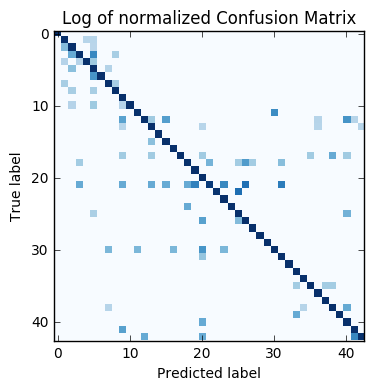

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001+cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

We observe some clusters in the confusion matrix above. It turns out that the various speed limits are sometimes misclassified among themselves. Similarly, traffic signs with traingular shape are misclassified among themselves. We can further improve on the model using hierarchical CNNs to first identify broader groups like speed signs and then have CNNs to classify finer features such as the actual speed limit.   

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I used Adam optimizer with learning rate = 0.007. Batch size of 64 was used and training was done for 30 epochs. The keep_prob for dropout layers was chosen to be 0.5 for conv layers and 0.7 for FC layers.  

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
* Starting with pre-processing stage, I tried several color channels including RGB, YUV and RGB with CLAHE. I chose RGB with CLAHE as it gave best results and I believe color carries useful information for our problem. 
* I chose architecture similar to VGGnet because deeper layers give better results and it is also quite elegant in the sense that same size filters for conv layers and pooling are used throughout. 
* Padding=1 or 'SAME' padding was used in conv layers to retain information at the borders of images.
* Batch size and the size of FC layers was mostly constrained by memory issues, and adding more neurons in FC layers didn't seem to help much with the accuracy.
* keep_prob in dropout for FC layers was chosen to be 0.7 because a smaller value of ~0.5 led to extremely slow convergence. 
* I used  Adam optimizer as it seems to automatically tune the learning rate with time.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [39]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import pandas as pd
sign_names = pd.read_csv('signnames.csv')
sign_names.head(10)

ClassId                     SignName
0        0         Speed limit (20km/h)
1        1         Speed limit (30km/h)
2        2         Speed limit (50km/h)
3        3         Speed limit (60km/h)
4        4         Speed limit (70km/h)
5        5         Speed limit (80km/h)
6        6  End of speed limit (80km/h)
7        7        Speed limit (100km/h)
8        8        Speed limit (120km/h)
9        9                   No passing

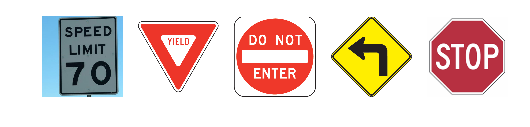

In [48]:
import glob
img_files = glob.glob('myData/*.jpg')
n_new = len(img_files)
new_data = np.zeros((n_new, 32,32,3), dtype=np.uint8)
fig, ax = plt.subplots(1,n_new)
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA) # resize to 32x32
    new_data[i] = img

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I have taken these US traffic signs from the web. The stop sign looks fairly easy. No entry and yield signs look similar to German counterparts, although there are some differences too, namely the text on the signs. The speed limit sign looks very different from the corresponding German speed-limit sign, the only similarity being the number '70'. The left turn sign is completely different. So, I don't expect classifier to work on the left turn sign and possibly also fail on the speed limit sign.  

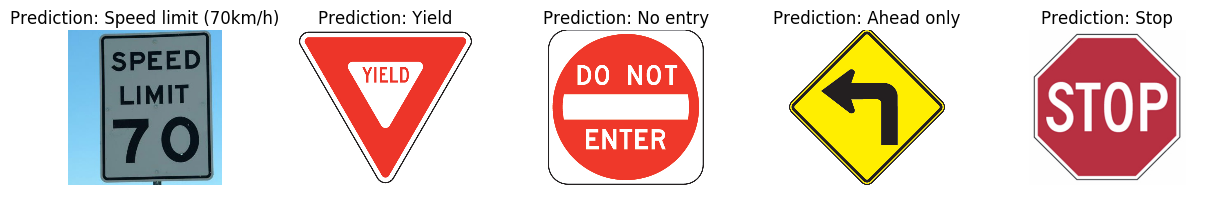

In [51]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(model_1.logits), k=top_k), 
                             feed_dict={x:X_data, keep_prob:1, keep_prob_conv:1})
    return y_prob,y_pred


# preprocess data  :
new_data_proc = np.zeros(new_data.shape)
for i in range(n_new):
    new_data_proc[i] = contrast_norm(new_data[i])
    
# make predictions
_, y_pred = y_predict_model(new_data_proc)

# show the prediction results
fig, ax = plt.subplots(1,n_new, figsize=(15,2))
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('Prediction: '+sign_names.iloc[y_pred[i][0]]['SignName'])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** I get an accuracy of 80% on the new dataset. This is actually better that what I had anticipated, my classifier worked even on the speed limit which looked very different from the German sign.

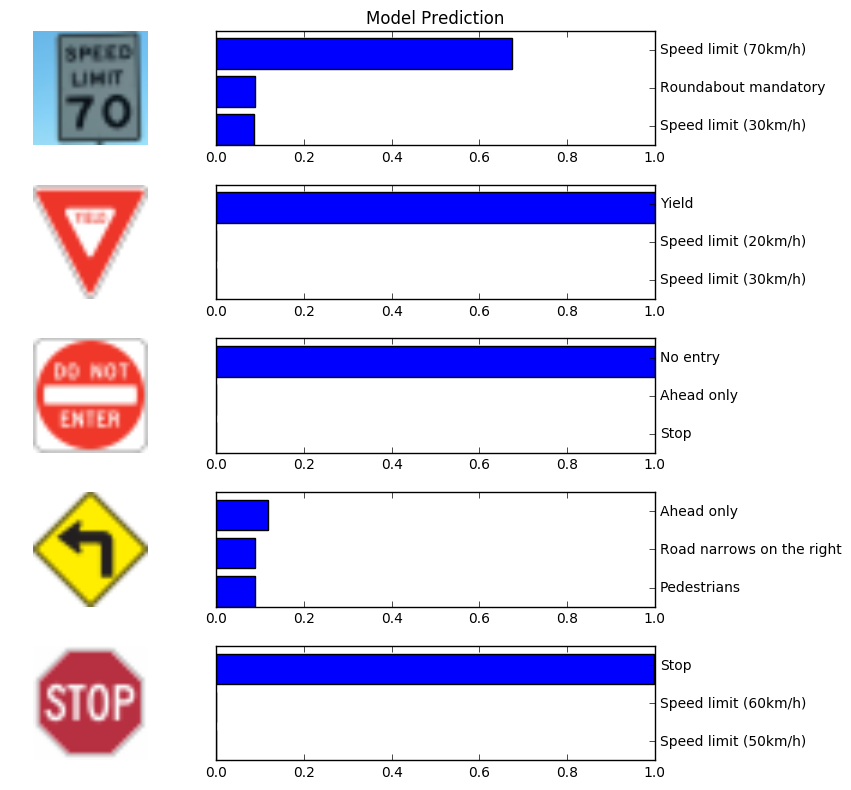

In [50]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

        
def visualize_models(X_data) :
    n_examples = len(X_data)
    fig, ax = plt.subplots(n_examples, 2,figsize=(10,8))
    
    X_data_proc = np.zeros(X_data.shape)
    for i in range(n_examples):
        X_data_proc[i] = contrast_norm(X_data[i])
    prob, pred = y_predict_model(X_data_proc, top_k=3)
    
    for i in range(n_examples) :
        labels = pred[i]
        names = [sign_names.iloc[l]['SignName'] for l in labels]
        bar_locations = np.arange(3)[::-1]
        ax[i,0].imshow(X_data[i])
        ax[i,0].axis('off')
        ax[i,1].barh(bar_locations, prob[i])
        ax[i,1].set_yticks(0.5+bar_locations)
        ax[i,1].set_yticklabels(names)
        ax[i,1].yaxis.tick_right()
        ax[i,1].set_xlim([0,1])
    ax[0,1].set_title('Model Prediction')
    fig.tight_layout()
    
visualize_models(new_data)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**  As can be seen above, my classifier predicts stop, yield and no-entry signs with a near 100% certainty. For the speed limit sign, it predicts the correct answer but with a lower probability of about 67%. For the left-turn sign, classifier is very uncertain with the best prediction barely over 10% certain and the correct prediction doesn't appear in the top 3.     

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.